<H1 align="center">Guiding question: What topics exist in these tweets?</H1>
<H2 align="center">author: Brian Lehman</H2>

# Introduction
Tinkering with some [old tweet data](https://github.com/DrSkippy/Data-Science-45min-Intros/tree/master/topic-modeling-201) that was gathered while the author worked at Gnip, context is provided for a brief consdieration of the author's python + viz skill.  


## Process
Topic modeling goes from a big mess, to organizational beauty via interesting math, then back to a big mess of subjective interpretations peppered with various levels of credibility. The attempt here is to gain some mastery over this credibility factor. Highlighing as much as possible in regards to the said interesting mathematics, what follows is an overview of this project's topic discovery process:

1. Setting up the environment
2. Loading the Data
3. Exploring the data
4. Pre-processing the data
5. Exploring topic modeling methods
6. Building an LDA model
7. Evaluating the LDA model 
8. Improving the LDA model using BERT embeddings
9. Visulizing the results
10. Discussing what we can learn from the results.
11. Discussing potential next steps.


### Virtual Environment
The env is available in the `tweet_topic_modeling_environment.yml` and was output in this way via command line:

* !`conda env export --from-history > environment.yml`.

See [creating-an-environment-from-an-environment-yml-file](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) on Conda's site to load the even. 

Side note: 
As I was adding packages to teh environment, I found it useful to add conda-forge to my channels
* `conda config --add channels conda-forge`
* `conda config --set channel_priority strict`
  
### kernel
After activating the conda environment, make the kernel accessible (see [stackoverflow](https://stackoverflow.com/a/44786736)):
* !`python -m ipykernel install --user --name tweet_topic_modeling --display-name "tweet_topic_modeling"`

### IDE
Jupyter Lab is used and the "tweet_topic_modeling" kernel is selected. 

* !`jupyter lab`
 
### Pip

After activating the env, the author uses `pip` to install a few libs:

* `python -m pip install langid langdetect torch gensim huggingface-hub langdetect langid nodejs pyLDAvis seaborn wordcloud nltk `

## Data Decision
Post Elon, the site formerly known as Twitter no longer makes tweet data freely available. This original data set arrives from one of the author's topic modeling projects from 2015 (see [topic-modeling-201](https://github.com/DrSkippy/Data-Science-45min-Intros/tree/master/topic-modeling-201) repo). The data contains 5,000 tweets using the search term "golden retreiver" that was freely snagged from Twitter's public API. 

### Data Issue & Implemented Solution

* issue: Less than 10% of the original tweet's text are unique; over 80% of the original tweets' text contains "**half pitbull half goden retriever**".
* solution: (accomplished below) over 50% uniqueness is obtained using some text replacement detailed in the Apple DataViz Team Special Edition section.

In [1]:
%%capture output

import pickle as pkl
with open('data/tweet_text.pkl', 'rb') as file:
    tweet_text = pkl.load(file)

from models.viz.utils import get_replaced_tweets
replaced_tweets = get_replaced_tweets()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from collections import Counter
print("-------------ORGINAL TWEET SET: MOST COMMON TWEETS-------------")
Counter(tweet_text).most_common(5)

-------------ORGINAL TWEET SET: MOST COMMON TWEETS-------------


[('RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
  1824),
 ('RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
  1387),
 ('RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
  672),
 ('RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
  95),
 ('RT @RetrieverPics: half pitbull half golden retriever https://t.co/q3wkO6mbtZ',
  60)]

In [3]:
import re
# Count the number of tweets containing the phrase "half pitbull half golden retriever"
count = sum(1 for tweet in tweet_text if re.search(r'half\s+pitbull\s+half\s+golden\s+retriever', tweet, flags=re.IGNORECASE))

# Output the count
print(f"Tweets containing 'half pitbull half golden retriever': {count}/5000 (>80%)")

Tweets containing 'half pitbull half golden retriever': 4147/5000 (>80%)


In [4]:
print(f'percent of original tweets unique: {100*len(set(tweet_text))/len(tweet_text)}%')

percent of original tweets unique: 8.96%


In [5]:
print(f'percent of replaced tweets unique: {100*len(set(replaced_tweets))/len(replaced_tweets)}%') 

percent of replaced tweets unique: 54.54%


In [6]:
#from collections import Counter
#print("-------------UPDATED TWEET SET: MOST COMMON TWEETS-------------)")
#Counter(replaced_tweets).most_common(5)

## **Apple DataViz Team Special Edition** (for funsies) 
Since most of these tweets contain the term "half pitbull half golden retriever," some Tom Robbins style whimsy along the names Apple's legendary DataViz teammates are selected with some randomness to build a new corpus. See `data_processing.py` for full details. 

In [7]:
from data.utils.data_processing import process_tweets
import random 

run = False
if run: 
    replaced_tweets = process_tweets(tweet_text)
    with open('data/whimsy_tweets.pkl','wb') as f:
        pkl.dump(replaced_tweets, f, protocol=pkl.HIGHEST_PROTOCOL)

print("-------------> NEW APPLE DATAVIZ TEAM TWEET SET <-------------")
### show updated tweet set
for tweet in random.sample(replaced_tweets, 5): 
    print(tweet)
    


-------------> NEW APPLE DATAVIZ TEAM TWEET SET <-------------
RT @PitbuIIs: half celestial bouncehouse disco dancing with penguins, half Adila https://t.co/5Q8blK2MHR
RT @PitbuIIs: half effervescent gazelle cartwheeling through galaxies, half Adila https://t.co/5Q8blK2MHR
RT @BabyAnimalPics: half celestial bouncehouse spelling words in the sky with fireflies, half Adila https://t.co/86vpNGZ9mr
RT @BabyAnimalPics: half celestial mermaid surfing on rainbows projected from kitten sneezes, half Adila https://t.co/86vpNGZ9mr
RT @PitbuIIs: half celestial parrot surfing on rainbows projected from kitten sneezes, half Adila https://t.co/5Q8blK2MHR


### Intial thoughts on data decision & ideas to explore
1. The data edit for the Apple DataViz Team is fire! The author cannot read these tweets without laughing. 
3. The RT in the text is an outdated way of establishing that a tweet is actually a retweet; remove it; not relevant to the topcs. 
4. In the first 10 tweets viewed, 8 had links, but only 1 link went to a non-suspended user.
    * What should we do with links in general?
        * note: following links can provide context and might be interesting; however, this is too much extra work for this project.
        * decision: focus purely on the text and remove the links.
5. The @ mentions should be removed to clean the text; not relevant to topics.  
6. Punctuation could be removed to clean the text; however, certain tools make use of punctuation for context. 
7. Stemming might be useful to test its affects the coherence scores. 
8. If "half" shows up as significantly weighted in the topics, the word "half" might be added to the stopwords list.
9. Build a baseline model to which we can compare our improvements.
10. ChatGPT can be used to kick things off because "AI" is wildly helpful at times.  


### Employ AI

**initial promp**: "I have text from 5000 tweets in a python list variable named `tweet_text`.  The text was pulled from a 2015 version of Twitter's free public API using "golden retriever" as the search term. I'd like to remove urls, remove the words that start with @ (these are the user mentions), remove the word "RT", remove punctuation from the text, and remove common stop words. I'd also like to lowercase all of the text, ~and use stemming~. Can you clean this data accordingly, split this list into a train and test set, train a topic model on the training set, and then label the test set using the topic model?"

#### run once
Just getting a quick house keeping project out of the way.

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lehman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lehman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Part I: Exploratory Analysis 
### Quick LDA Modeling scratch work
The scratch work done here is mostly to tinker with parameters and just get a feel for how the LDA process works. 
* "half" is added to stopwords, which makes the tweet text read oddly when printed below. 
* topics are printed
* sample tweets with topic probab are shown
* a coherence score is calculated using `c_v` and `u_mass` respectively.
* mapping from the pre-processed and uniqued tweets back to the original offered insight into the one to many relationship.

In [9]:
from models import LDA_m3
from models.viz.utils import get_replaced_tweets
from models.viz.utils import print_results
print_results(*LDA_m3.main(get_replaced_tweets()))

Initial tweets: 5000
Unique tweets: 1204
Training tweets: 782
Test tweets: 422
Total topics: 3

Topics and their meanings:
Topic 0: 0.056*"patrick" + 0.045*"sesh" + 0.028*"dogs" + 0.025*"playing" + 0.024*"ghosts" + 0.024*"prairie" + 0.024*"pattycake" + 0.023*"hamster" + 0.023*"whispering" + 0.023*"badger"
Topic 1: 0.088*"adila" + 0.046*"sesh" + 0.022*"love" + 0.020*"moon" + 0.020*"songs" + 0.020*"singing" + 0.018*"rainbows" + 0.018*"sneezes" + 0.018*"surfing" + 0.018*"kitten"
Topic 2: 0.061*"patrick" + 0.023*"sesh" + 0.021*"ferret" + 0.021*"riding" + 0.021*"unicorns" + 0.021*"friendly" + 0.020*"trading" + 0.020*"thunderbolts" + 0.020*"otter" + 0.020*"baby"
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2

In [10]:
%%time 
from models.LDA_m3 import create_mapping
from models.viz.utils import get_replaced_tweets
lda_model, tweet_texts, num_topics, unique_tweet_texts, train_texts, train_tokens, test_texts, dictionary, test_corpus, train_corpus = LDA_m3.main(get_replaced_tweets())

CPU times: user 23.3 s, sys: 2.76 s, total: 26 s
Wall time: 6.82 s


In [11]:
%%time
mapping = create_mapping(unique_tweet_texts, tweet_texts)

CPU times: user 647 ms, sys: 42 ms, total: 689 ms
Wall time: 690 ms


In [12]:
print("-------------------------------------------------------------")
print("5 ORIGINAL tweets with their topic label and probability:")
print("-------------------------------------------------------------")
for i, doc in enumerate(random.sample(test_corpus, 5)):
    
    print(f"ORIGINAL tweet: {mapping[unique_tweet_texts[i]]}")
    topic_distribution = lda_model.get_document_topics(doc)
    for topic, proba in topic_distribution:
        print(f"Topic label: {topic} Probability:{proba}")
    print("-------------------------------------------------------------")
    print("")

-------------------------------------------------------------
5 ORIGINAL tweets with their topic label and probability:
-------------------------------------------------------------
ORIGINAL tweet: ['RT @Goals4Dudes: half magnificent solar flare blowing kisses to auroras, half Sesh https://t.co/MNf647Tr6r', 'RT @BabyAnimalPics: half magnificent solar flare blowing kisses to auroras, half Sesh https://t.co/86vpNGZ9mr']
Topic label: 0 Probability:0.016205737367272377
Topic label: 1 Probability:0.9666926860809326
Topic label: 2 Probability:0.01710158959031105
-------------------------------------------------------------

ORIGINAL tweet: ['RT @BabyAnimalPics: half radiant mermaid surfing on rainbows projected from kitten sneezes, half Adila https://t.co/86vpNGZ9mr', 'RT @Goals4Dudes: half radiant mermaid surfing on rainbows projected from kitten sneezes, half Adila https://t.co/MNf647Tr6r', 'RT @BabyAnimalPics: half radiant mermaid surfing on rainbows projected from kitten sneezes, half Ad

### Thoughts on output 
1. What size is this dataset after pre-processing and uniquing?
   * 5000 original tweets to 1335 unique tweets seems surprisingly small.
   * note: the mapping above explains it. The one to many mapping happens after we pre-process the text. 
1. Are the topics very distinct? Meaning, are the probabilities for the tweets predicting one clear winner or are the probabilities roughly equal across all topics?
    * plot max proba by topic in a violin plot or try the rain cloud. Maybe use Altair.
    * Better yet, try pyLDAvis! (save for later)
    * low alpha values keep the topics tight and higher values let documents be associated with more topics. <-- vary this parameter. 
1. The meaning of the topics is opaque. How can the meaning be extracted?
    * First, determine the number of topics: maybe plot various coherence scores by changing the number of topics in the LDA modeling and find an elbow.
1. The language filter seems like a good idea at least for making meaning of the topics. 

### Choose lang lib
Goal: priority is given to the conservative model (ie. filter less Tweets not more) as our set is getting thing with the uniques. 
* The spot check didn't surface anything in either group that seems suspicous
* The`langid` lib ran faster
* The `langid` lib is more conservative

The `langid` lib wins. 

In [13]:
%%time 
from langdetect import detect

# Filter out non-English tweets
english_tweets = []
for tweet in tweet_text:
    try:
        if detect(tweet) == 'en':
            english_tweets.append(tweet)
    except:
        pass  # Skip tweets that raise exceptions (e.g., empty tweets)

CPU times: user 39.3 s, sys: 89.2 ms, total: 39.4 s
Wall time: 39.5 s


In [14]:
len(english_tweets)

4093

In [15]:
import random
random.sample(english_tweets, 20)

['RT @BiIlionaires: half pitbull half golden retriever https://t.co/wujTGuhAWd',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'I could really use a golden retriever to lay at my feet and keep them warm currently.',
 'RT @BabyAnimalPics: half pitbull half 

In [16]:
%%time 
import langid

# Filter out non-English tweets
english_tweets_langid = []
for tweet in tweet_text:
    lang, _ = langid.classify(tweet)
    if lang == 'en':
        english_tweets_langid.append(tweet)

print(len(english_tweets_langid))

4664
CPU times: user 16.9 s, sys: 2.05 s, total: 18.9 s
Wall time: 2.57 s


In [17]:
random.sample(english_tweets_langid, 20)

['RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @RetrieverPics: half pitbull half golden retriever https://t.co/q3wkO6mbtZ',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever

# Part II: Build Baseline Model

### Coherence by Topic Count: Baseline Model Selection

The author would love to tinker with [OCTIS](https://github.com/MIND-Lab/OCTIS?tab=readme-ov-file#evaluate-a-model) or find other fun tools, but for the sake of demonstration, this study simply varies a few paramaters (and not across all of their repsective spaces). This decision was made based on building a few quick models in advance and seeing what parameters change the coherence the most. In this code, we vary the parameters of 5 models and using *coherence scores* as our eval metric. The best model will become our baseline for the next section. 

### BASELINE VERSION \#1
* input: `get_replaced_tweets()` - some edited tweet described above. 
* method: `LDA_coherence()` - pseudo grid style search of a few parameters that seemed important in the exploratory analysis.
* output: `json` - useful as a pandas dataframe.

#### Data
Results from using 5 models across various topic values are reviewed below.

In [18]:
run = False
if run: 
    import models.LDA_coherence_revised as LDA_coherence
    from models.viz.utils import get_replaced_tweets
    df_data_fugly = LDA_coherence.main(get_replaced_tweets())
else:
    import pickle as pkl
    with open('data/df_data_fugly.pkl','rb') as f:
        df_data_fugly = pkl.load(f)
     

In [19]:
import pandas as pd
df_coherence = pd.DataFrame(df_data_fugly)
df_coherence.rename(columns={'coherence_scores_umass':'u_mass','coherence_scores_cv':'c_v'}, inplace=True)
df_coherence.head()

,num_topics,method,alpha,eta,u_mass,c_v,model
0,3,m1,auto,symmetric,-15.138827,0.385767,"LdaModel<num_terms=709, num_topics=3, decay=0...."
1,3,m1,symmetric,symmetric,-15.084933,0.378617,"LdaModel<num_terms=709, num_topics=3, decay=0...."
2,3,m2,auto,symmetric,-15.138827,0.385767,"LdaModel<num_terms=709, num_topics=3, decay=0...."
3,3,m2,symmetric,symmetric,-15.084933,0.378617,"LdaModel<num_terms=709, num_topics=3, decay=0...."
4,3,m2,auto,auto,-15.138827,0.385767,"LdaModel<num_terms=709, num_topics=3, decay=0...."


#### Viz Challenge
The challege: represent two coherence scales ('c_v' and 'u_mass") across 5 models for various values of n topics. The viz should show the best model and best choice for n topics. The author is not a huge fan of such charts, but the goal here is to find an ideal supported both by 'c_v' and 'u_mass' methods. Only 5 combinations of paramaters exist in the data (see below); however, this is a limited set for what could have been varied and this set alone means that 10 separate lines (5 for each coherence scale) need to be plotted. A gray scale with line pop on hover would be a fun way to see the model quality but might not be worth the time. Let's play and see what we find. 

In [20]:
df_coherence[['method', 'alpha', 'eta']].drop_duplicates()

,method,alpha,eta
0,m1,auto,symmetric
1,m1,symmetric,symmetric
2,m2,auto,symmetric
3,m2,symmetric,symmetric
4,m2,auto,auto


In [21]:
%%capture output
from models.viz.utils import build_fugly_brokeness

data = df_coherence.loc[:,['c_v','u_mass','num_topics', 'eta','alpha','method']]
coherence_chart = build_fugly_brokeness(data)

#### What can we learn from a broken chart?
Ugly and incorrect, this chart still has some candy. 

Some reasons to consider why this chart is broken:
* Most of the individual values for `c_v` and `u_mass` are plotted together; so the individual models' performance is obscured.
* Use of hover only shows a limited number of data points, which suggests overlap. Why are so many of the values the same?
* Quite simply: this doesn't pass the sniff test. 

Some reasons to cofirm this chart may still be helpful:
* The simplicity of the two lines is actually beneficial for readibility. 
* The tightness of the points on the lines actually means that little variation occurs across the 5 models for each coherence score (assuming all of the points are actually being plotted because we surely cannot find them).



In [22]:
coherence_chart

/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col =

alt.LayerChart(...)

#### Why did this chart break?
Fire up the data exploration! 
* Only 36/90 (40%) of the scores are unique
* So the parameter changes didn't have an effect OR we have an issue in the code.

**NOTE: an issue in the code was discovered.** On a thrid attempt, ChatGPT found this error. 
<h5 align="center">issue:`train_tokens_m2 = [text.split() for text in train_texts_m1]` -----------> fix:`train_tokens_m2 = [text.split() for text in train_texts_m2]` </h5>

#### Learning note
* coding fast without making tests can be equivalent to coding slow.

In [26]:
df_cohmelt = df_coherence.melt(id_vars=['num_topics', 'method', 'alpha'], 
                    value_vars=['u_mass', 'c_v'], 
                    var_name='coherence_metric', value_name='coherence_score')


In [27]:
df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].shape

(90, 5)

In [28]:
df_cohmelt[df_cohmelt.coherence_metric=='c_v'].shape

(90, 5)

In [36]:
print(f"Only {(100*df_cohmelt[df_cohmelt.coherence_metric=='c_v'].coherence_score.unique().shape[0]/df_cohmelt[df_cohmelt.coherence_metric=='c_v'].shape[0])}% of 'c_v' scores are unique?")

Only 40.0% of 'c_v' scores are unique?


In [43]:
print(f"And...only {(100*df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].coherence_score.unique().shape[0]/df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].shape[0])}% of 'u_mass' scores are unique?! Sniff test failure.")

And...only 40.0% of 'u_mass' scores are unique?! Sniff test failure.


### BASELINE VERSION \#2
* removed ETA as a parameter; it wasn't adding much value.
* use 4 models (instead of 5) over which to vary the number of topics
* added a new var to the data post processing called `model_name`
* ran 20 passes instead of 25
* stopped using stemming; it wasn't adding much value.
* kept the pre-processing set full for method 1 
* overall, these changesd slimmed the parameter space and distinguised the models.
* fixed the error in the code that was creating the same scores previously.
The results are briefly explored before making a visual.

In [44]:
run = False
if run:
    import models.LDA_coherence_revised as LDA_coherence_revised
    from models.viz.utils import get_replaced_tweets
    df_data = LDA_coherence_revised.main(get_replaced_tweets())
else:
    import pickle as pkl
    with open('data/df_data_baseline_20passes.pkl','rb') as f:
        df_data = pkl.load(f)
        df_data.pop('eta') 

#### Data
Results from using 4 models across various topic values are reviewed below.
* notice that the `eta` column is removed.
* notice the new column, `model_name`, which is key to how the visual is made.
    * `model_name` - the concatenation of `method` \+ `alpha` 

In [45]:
import pandas as pd
df_coherence = pd.DataFrame(df_data)
df_coherence.rename(columns={'coherence_scores_umass':'u_mass','coherence_scores_cv':'c_v'}, inplace=True)
df_coherence['model_name'] = df_coherence['method'] + df_coherence['alpha']
df_coherence.head()

,num_topics,method,alpha,u_mass,c_v,model,model_name
0,3,m1,auto,-12.898237,0.313248,"LdaModel<num_terms=794, num_topics=3, decay=0....",m1auto
1,3,m1,symmetric,-14.982072,0.338290,"LdaModel<num_terms=794, num_topics=3, decay=0....",m1symmetric
2,3,m2,auto,-15.251148,0.348585,"LdaModel<num_terms=744, num_topics=3, decay=0....",m2auto
3,3,m2,symmetric,-14.686577,0.354204,"LdaModel<num_terms=744, num_topics=3, decay=0....",m2symmetric
4,4,m1,auto,-13.704133,0.310756,"LdaModel<num_terms=794, num_topics=4, decay=0....",m1auto


In [46]:
df_cohmelt = df_coherence.melt(id_vars=['num_topics', 'method', 'alpha'], 
                    value_vars=['u_mass', 'c_v'], 
                    var_name='coherence_metric', value_name='coherence_score')


#### Scores Unique?
The expectation is that most of the 72 possible scores are different for all four models.
* Only 2 scores will overlap this time in the `c_v` model. 

In [47]:
print(f"Total u_mass scores: {df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].shape[0]}")

Total u_mass scores: 72


In [48]:
print(f"total `c_v` scores: {df_cohmelt[df_cohmelt.coherence_metric=='c_v'].shape[0]}")

total `c_v` scores: 72


In [49]:
print(f"toal unique `c_v` scores: {df_cohmelt[df_cohmelt.coherence_metric=='c_v'].coherence_score.unique().shape[0]}")

toal unique `c_v` scores: 70


In [50]:
print(f"toal unique `u_mass` scores: {df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].coherence_score.unique().shape[0]}")

toal unique `u_mass` scores: 72


In [51]:
import numpy as np
max_cv = df_data['coherence_scores_cv'][np.argmax(df_data['coherence_scores_cv'])]
max_umass = df_data['coherence_scores_umass'][np.argmax(df_data['coherence_scores_umass'])]

In [52]:
max_row_index = df_coherence['c_v'].idxmax()

# Retrieve the row using the index
max_row = df_coherence.loc[max_row_index]

print("Row with max c_v:")
print(max_row)

Row with max c_v:
num_topics                                                    9
method                                                       m2
alpha                                                 symmetric
u_mass                                                -10.96134
c_v                                                     0.44869
model         LdaModel<num_terms=744, num_topics=9, decay=0....
model_name                                          m2symmetric
Name: 27, dtype: object


In [53]:
min_row_index = df_coherence['u_mass'].idxmin()

# Retrieve the row using the index
min_row = df_coherence.loc[min_row_index]

print("Row with min u_mass:")
print(min_row)

Row with min u_mass:
num_topics                                                    4
method                                                       m2
alpha                                                 symmetric
u_mass                                               -16.410907
c_v                                                    0.357098
model         LdaModel<num_terms=744, num_topics=4, decay=0....
model_name                                          m2symmetric
Name: 7, dtype: object


#### Four Models

In [54]:
from IPython.display import display
print(f"The four above models will be viewed across the coherence scoring techniques: {display(df_coherence[['method', 'alpha']].drop_duplicates())}\n\n")

,method,alpha
0,m1,auto
1,m1,symmetric
2,m2,auto
3,m2,symmetric


The four above models will be viewed across the coherence scoring techniques: None




### Visualization

#### Viz Challenge 
* The challege: represent two coherence scales ('c_v' and 'u_mass") across 4 models for various values of n topics. The viz should show the best model and best choice for n topics.
    * Build a dual axis chart 
* Dual Axis Challenge: how to indicate to the reader which points on the graph belong to which axis?
  * Subtle and intuitive use of color (ie. match axis label with border on points); colors need some work, but the idea has a runway. 

#### Dual Axis Chart Learnings?

* The higher scoring `m2symmetric` and `m2auto` models' `c_v` scores suggest an elbow at 7 or 9 (somewhat disregarding  what happens at 8).
* The lower `c_v` scores from `m1symmetric` and `m1auto` suggest an elbow around 4 and 12 topics. 
* The `u_mass` scores suggest an elbow somewhwere betwee 8 and 10 for all models.
* The author is picking the `m2symmetric` to do further exploratory analysis. 

In [55]:
%%capture output
import altair as alt
from models.viz.utils import add_properties, get_altair_css    
from models.viz.utils import build_multiline_altair
data = df_coherence.loc[:,['c_v','u_mass','num_topics','alpha','method','model_name']]
coherence_chart = build_multiline_altair(data) #note: strokeWidth=alt.value(4) <-- play with this in u_mass plot

In [56]:
coherence_chart

/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col =

alt.LayerChart(...)

### What are the topics for the `m2symmetric` model?
Just at first glance, these are topics about individuals named Sesh, Patrick, and Adila. So wild! =] The coherence scores are not particularly high so we might expect the topics to feel a little loose in definition/meaning. 

#### Topics  

In [57]:
logic = ((df_coherence["model_name"]=="m2symmetric") & (df_coherence['num_topics']==9))
m2sym9 = df_coherence[logic]['model'].values[0]

In [58]:
m2sym9.print_topics()

[(0,
  '0.093*"patrick" + 0.033*"dogs" + 0.032*"whispering" + 0.032*"host" + 0.032*"ceremonial" + 0.032*"honey" + 0.032*"trees" + 0.032*"weddings" + 0.032*"badger" + 0.032*"playing"'),
 (1,
  '0.108*"sesh" + 0.095*"kisses" + 0.095*"auroras" + 0.095*"blowing" + 0.027*"enchanting" + 0.016*"peculiar" + 0.016*"transcendent" + 0.016*"whirlpool" + 0.015*"adila" + 0.015*"star"'),
 (2,
  '0.072*"patrick" + 0.066*"find" + 0.063*"sand" + 0.063*"polecats" + 0.063*"dunes" + 0.063*"mystic" + 0.063*"breeds" + 0.063*"prince" + 0.063*"cruising" + 0.012*"guide"'),
 (3,
  '0.082*"patrick" + 0.072*"baby" + 0.069*"trading" + 0.069*"manifesting" + 0.069*"otter" + 0.069*"thunderbolts" + 0.065*"cartwheeling" + 0.065*"galaxies" + 0.014*"frenetic" + 0.013*"meteor"'),
 (4,
  '0.175*"adila" + 0.062*"dancing" + 0.062*"penguins" + 0.062*"disco" + 0.046*"celestial" + 0.030*"bouncehouse" + 0.027*"volcano" + 0.027*"sunflower" + 0.025*"cloud" + 0.024*"parrot"'),
 (5,
  '0.136*"adila" + 0.054*"ocean" + 0.054*"moonwalki

#### Oh no! Wordclouds?
A fun game to play with word clouds and topics is to pick the words that don't belong, but the author see interelatedness as a thread here. Reflections by topic:

* Topic 0: Patrick has a side gig as a dog whisperer at weddings
* Topic 1: Sesh and Adila are both super into outerspace as long as it inovles kisses directed to the sky (Sesh is super into this while Adila is more of a hobbyist).
* Topic 2: Patrick is on a mission to find sand possibly using polecats and princes as guides.
* Topic 3: Baby Patrick is super popular apparently with Thor like qualities manifesting thunderbolts.
* Topic 4: Adila's bouncehouse was built near a volcano to host dancing penguins that want to look up at celestial events.
* Topic 5: ...
* ...

Such fun!  

In [59]:
from models.viz.utils import generate_word_clouds

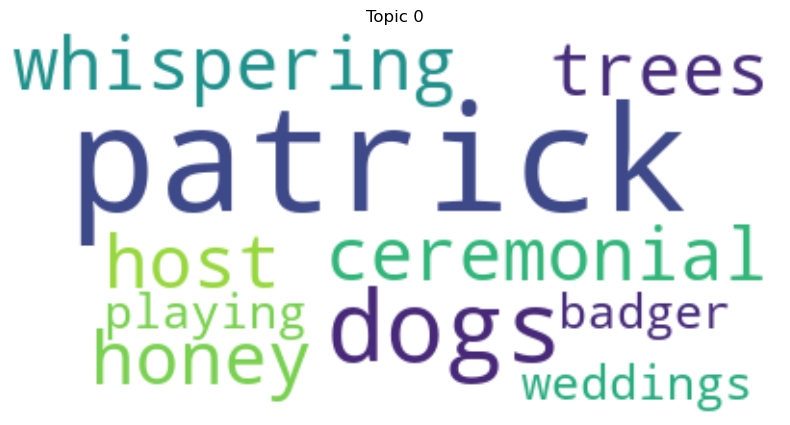

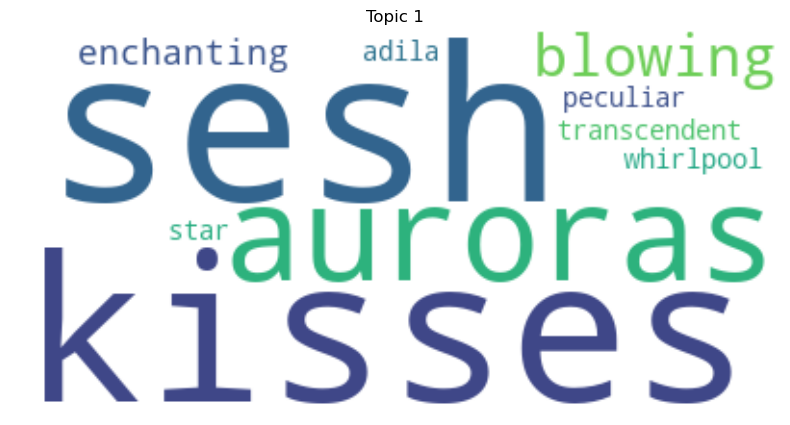

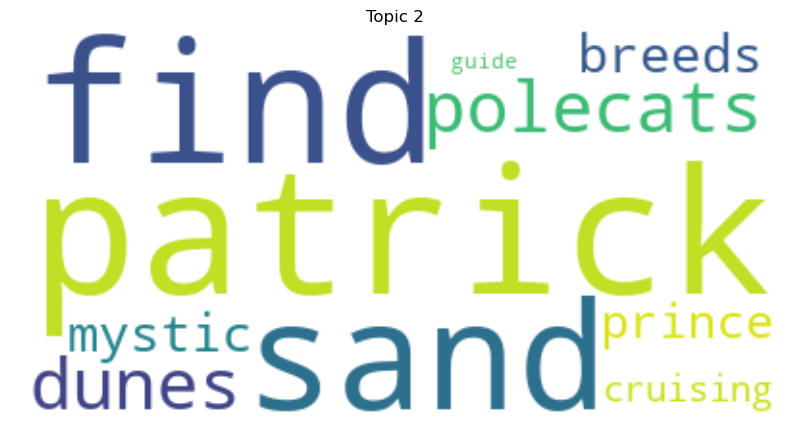

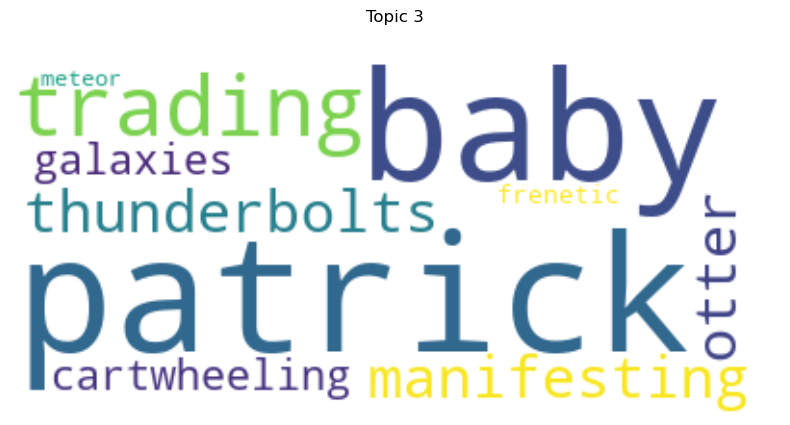

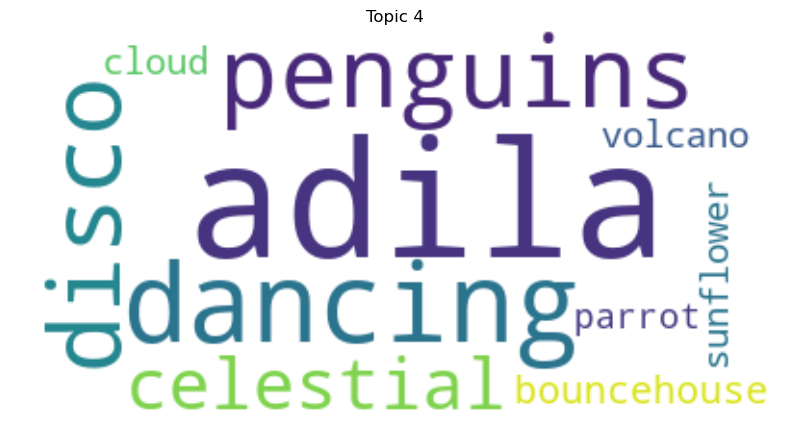

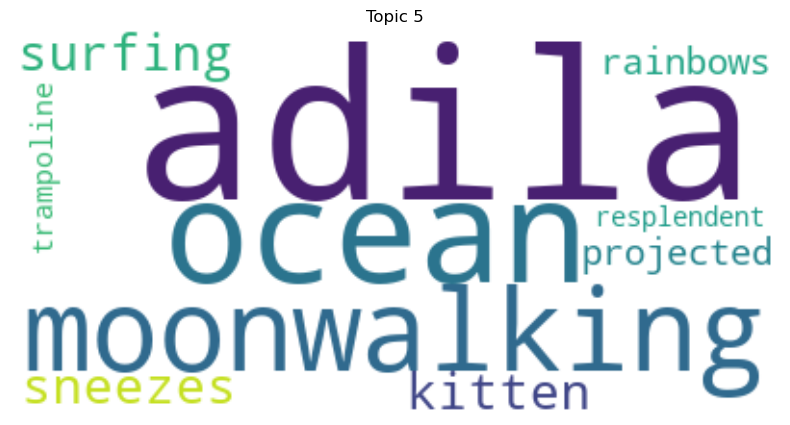

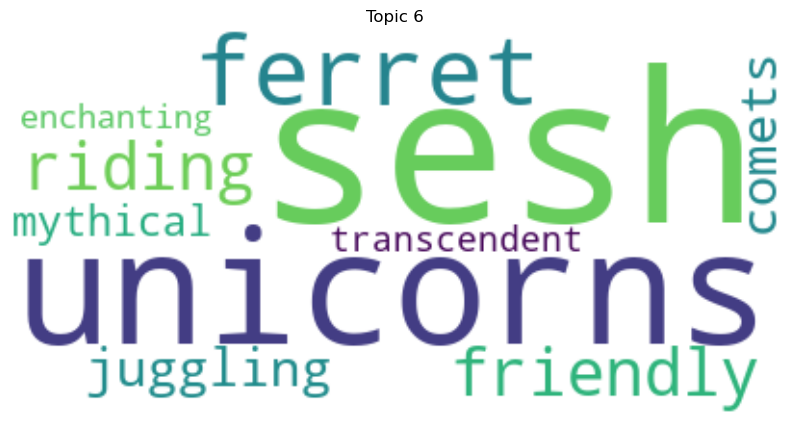

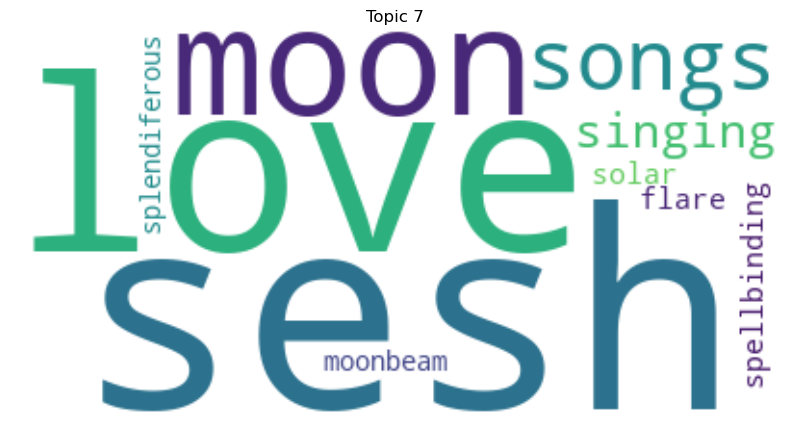

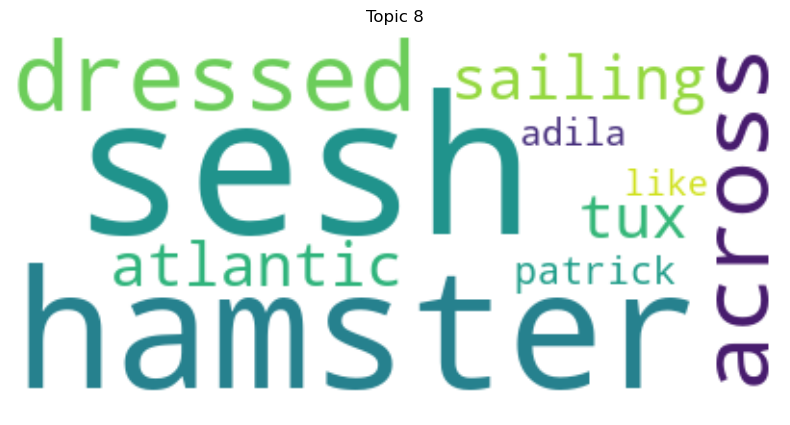

In [60]:
generate_word_clouds(m2sym9)

### Topic Meaning | pyLDAvis for m2symmetric
Reflections:
1. 

In [67]:
len(train_corpus)

782

In [1]:
from models import build_m2_models
from models.viz.utils import get_replaced_tweets
df_data, lda_model, train_corpus, dictionary, mapping = build_m2_models.main(get_replaced_tweets())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/schemapi.py:353: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(root or schema)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/altair/utils/schemapi.py:353: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import random
import re
import gensim
import pickle as pkl
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import CoherenceModel
from models.viz.utils import filter_lang
from collections import defaultdict
from models.viz.utils import get_replaced_tweets

def create_mapping(unique_tweet_texts, tweet_texts):
    """
    Create a mapping from unique tweet texts to tweet texts.
    
    Args:
    - unique_tweet_texts (list): List of unique preprocessed tweet texts.
    - tweet_texts (list): List of original tweet texts.
    
    Returns:
    - mapping (dict): Mapping from unique tweet texts to tweet texts.
    """
    mapping = defaultdict(list)
    
    # Iterate through each original tweet text
    for tweet_text in tweet_texts:
        # Preprocess the tweet text
        preprocessed_text = preprocess_text(tweet_text)
        
        # If the preprocessed text is in the set of unique preprocessed tweet texts
        if preprocessed_text in unique_tweet_texts:
            # Add the original tweet text to the corresponding list in the mapping
            mapping[preprocessed_text].append(tweet_text)
    
    return mapping   
    
def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    
    stop_words = set(stopwords.words('english'))

    # Remove URLs, user mentions, 'RT', punctuation, non-alphabetic characters
    text = re.sub(r'http\S+|@\w+|\bRT\b|[^a-zA-Z\s]', '', text)
    
    # Tokenization, lowercase, and removal of stopwords
    words = word_tokenize(text.lower())
    stop_words = stop_words.union(set(['half']))
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

def get_coherence_score(lda_model, train_tokens, dictionary, coherence_method):
    """Get coherence score for the given LDA model and method."""
    return CoherenceModel(model=lda_model, texts=train_tokens, dictionary=dictionary, coherence=coherence_method).get_coherence()
      
def pickle_file(obj, obj_name, method='m2', alpha='symmetric'):
    """Save object to a pickle file."""
    with open(f"data/{obj_name}_baseline_{f'{method+alpha}'}.pkl", 'wb') as f:
        pkl.dump(obj, f, protocol=pkl.HIGHEST_PROTOCOL)
        
def main(tweet_texts, num_topics=9,method='m2',alpha='symmetric',passes=20,per_word_topic=True,random_state=42):
    """Main function to perform topic modeling."""
    # setup
    # Keep only tweets classified as English
    tweet_texts_filtered = filter_lang(tweet_texts)
    pickle_file(tweet_texts_filtered, "tweet_texts_filtered")
        
    # Clean and unique the tweet texts
    unique_tweet_texts = list(set([preprocess_text(text) for text in tweet_texts_filtered]))
    pickle_file(unique_tweet_texts, "unique_tweet_texts")
    
    # Split data into train and test sets
    train_texts, test_texts = train_test_split(unique_tweet_texts, test_size=0.35, random_state=random_state)
    pickle_file(train_texts, "train_texts")
    pickle_file(test_texts, "test_texts")
    
    # Tokenize again for training LDA
    train_tokens = [text.split() for text in train_texts]
    pickle_file(train_tokens, "train_tokens" )
    
    # Create dictionary and corpus for topic modeling
    dictionary = corpora.Dictionary(train_tokens)
    pickle_file(dictionary, "dictionary")
    
    train_corpus = [dictionary.doc2bow(tokens) for tokens in train_tokens]
    pickle_file(train_corpus, "train_corpus")

    df_data = {
        "num_topics": [num_topics],
        "method": [method],
        "alpha": ['symmetric'],
        "coherence_scores_umass": [],
        "coherence_scores_cv": [],
        "model": []
    }
    param = {
        "corpus": train_corpus,
        "id2word": dictionary,
        "num_topics": num_topics,
        "random_state": random_state,
        "passes":passes,
        "per_word_topics": per_word_topic,
        "alpha": 'symmetric'
    }
    lda_model = gensim.models.ldamodel.LdaModel(**param)
    pickle_file(lda_model, "lda_model")

    # Get coherence scores
    coherence_scores_umass = get_coherence_score(lda_model, train_tokens, param['id2word'], 'u_mass')
    coherence_scores_cv = get_coherence_score(lda_model, train_tokens, param['id2word'], 'c_v')

    # Append data to dataframe
    df_data["coherence_scores_umass"].append(coherence_scores_umass)
    df_data["coherence_scores_cv"].append(coherence_scores_cv)
    df_data["model"].append(lda_model)


    print(f"---------------------------------------num_topics=={num_topics}---------------------------------------")

    
    lda_display = gensimvis.prepare(lda_model, train_corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

main(get_replaced_tweets())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x000000020360a240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000204b7e240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000201296240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000201418240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys s

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [75]:
from gensim import corpora
import pickle as pkl
with open('data/train_texts_m2_baseline_20passes.pkl','rb') as f:
    train_texts_m2 = pkl.load(f)
train_tokens_m2 = [text.split() for text in train_texts_m2]

dictionary_m2 = corpora.Dictionary(train_tokens_m2)

train_corpus_m2 = [dictionary_m2.doc2bow(tokens) for tokens in train_tokens_m2]

logic = ((df_coherence["model_name"]=="m2symmetric") & (df_coherence['num_topics']==9))
m2sym9 = df_coherence[logic]['model'].values[0]

lda_display = gensimvis.prepare(m2sym9, train_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000202d4c240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000204e70240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x000000020140d240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x00000002016d9240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys s

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
lda_display = gensimvis.prepare(m2sym9, train_corpus_m2, dictionary_m2, sort_topics=False)
pyLDAvis.display(lda_display)

In [73]:
import pickle as pkl
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

logic = ((df_coherence["model_name"]=="m2symmetric") & (df_coherence['num_topics']==9))
m2sym9 = df_coherence[logic]['model'].values[0]
with open('data/train_corpus_m2_baseline_20passes.pkl','rb') as f:
    train_corpus = pkl.load(f)
with open('data/dictionary_m2_baseline_20passes.pkl','rb') as f:
    dictionary = pkl.load(f)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000204717240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000200ef0240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000202acb240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x000000020139d240 (most recent call first):
  <no Python frame>
Fatal Python error: init_sys_streams: can't initialize sys s

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [61]:
! mv data/train_corpus_m2_baseline_25passes.pkl data/train_corpus_m2_baseline_20passes.pkl 

In [63]:
! mv data/dictionary_m2_baseline_25passes.pkl data/dictionary_m2_baseline_20passes.pkl

In [15]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_display = gensimvis.prepare(lda_model, train_corpus, dictionary, sort_topics=False)
# Display the visualization
pyLDAvis.display(lda_display)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
# import plotly.graph_objects as go

# # Extract topics and associated terms from the LDA model
# topics_terms = lda_model.show_topics(formatted=False)

# # Extract topic-term distributions for each topic
# topic_terms = {idx: [term for term, _ in topic] for idx, topic in topics_terms}

# # Create bar plots for each topic showing the top terms
# fig_terms = go.Figure()
# for idx, terms in topic_terms.items():
#     fig_terms.add_trace(go.Bar(x=terms, y=[1]*len(terms), name=f'Topic {idx}', orientation='h'))

# fig_terms.update_layout(title='Top Terms in Each Topic', barmode='stack', xaxis_title='Term', yaxis_title='Topic')
# fig_terms.show()

# # Extract topic-document distributions for the test set
# topic_distribution_test = [lda_model.get_document_topics(doc) for doc in test_corpus]

# # Create stacked bar plot showing topic distribution in test documents
# fig_distribution = go.Figure()
# for idx, topic_dist in enumerate(topic_distribution_test):
#     probs = [prob for _, prob in topic_dist]
#     fig_distribution.add_trace(go.Bar(x=[f'Topic {i}' for i in range(len(probs))], y=probs, name=f'Document {idx}'))

# fig_distribution.update_layout(title='Topic Distribution in Test Documents', barmode='stack', xaxis_title='Topic', yaxis_title='Probability')
# fig_distribution.show()

In [17]:
topic_terms = {}
for idx, topic in lda_model.print_topics(-1):
    terms = [term.split("*")[1].strip().strip('"') for term in topic.split("+")]
    topic_terms[f"Topic {idx}"] = terms

# Print topic-term distributions
for topic, terms in topic_terms.items():
    print(f"{topic}: {terms}")

topic_terms_with_counts = [{ 'topic': topic, 'count': len(terms) } for topic, terms in topic_terms.items()]


Topic 0: ['golden', 'retriev', 'wish', 'bulldog', 'get', 'lab', 'na', 'famili', 'upper', 'class']
Topic 1: ['retriev', 'golden', 'half', 'dog', 'cute', 'pitbul', 'like', 'puppi', 'get', 'name']
Topic 2: ['retriev', 'golden', 'half', 'pitbul', 'puppi', 'got', 'dog', 'want', 'realli', 'need']
Topic 3: ['golden', 'retriev', 'life', 'littl', 'mix', 'ive', 'theyr', 'first', 'thing', 'need']
Topic 4: ['golden', 'retriev', 'phoenix', 'help', 'look', 'absolut', 'walk', 'adopt', 'guid', 'he']


### Reflection
1. a few of the clusters seemed to overlap on the topic map, but running LDA a few more times let randomness change the positions. 
2. I'm not seeing a rich "theme" in the topic content. I'm going to try to use BERT embeddings to represent the text data and then apply LDA to find topics.

### BERT + LDA thoughts
... 

In [ ]:
from models.viz.utils import visualize_pyldavis
from models import BERT_LDA_m1
lda_model, bow_corpus, lda_dictionary = BERT_LDA_m1.main(tweet_text, wordcloud=True,pyldavis=True)
visualize_pyldavis(lda_model, bow_corpus, lda_dictionary)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
1+1

In [ ]:
import re
import torch
from transformers import BertTokenizer, BertModel
from gensim.corpora import Dictionary
import gensim
import langid
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel

def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    return re.sub(r'http\S+|@\w+|\bRT\b', '', text)

def tokenize_and_embed_tweets(tokenizer, bert_model, tweets):
    """Tokenize and embed tweets using BERT."""
    embeddings = []
    for tweet in tweets:
        encoded_tweet = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**encoded_tweet)
        embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

def train_lda_model(corpus, dictionary):
    """Train an LDA model."""
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,
                                           random_state=42,
                                           passes=10,
                                           per_word_topics=True)

def visualize_wordclouds(lda_model):
    """Visualize Word Clouds for each topic."""
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for topic_id, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis('off')
        plt.show()

def visualize_pyldavis(lda_model, corpus, dictionary):
    """Visualize pyLDAvis."""
    lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

def compute_coherence(lda_model, corpus, dictionary):
    """Compute Topic Coherence."""
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')


# Sample list of 5000 tweet texts
tweet_texts = tweet_text  

# Keep only tweets classified as English
english_tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

# Preprocess and tokenize texts
preprocessed_texts = [preprocess_text(text) for text in english_tweet_texts]

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).eval()

# Tokenize and embed tweets using BERT
bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)

# Convert BERT embeddings to a format suitable for LDA
flattened_bert_embeddings = [emb.flatten() for emb in bert_embeddings]

# Train LDA model on bag-of-words representations
lda_dictionary = Dictionary([word_tokenize(text) for text in preprocessed_texts])
bow_corpus = [lda_dictionary.doc2bow(word_tokenize(text)) for text in preprocessed_texts]
lda_model = train_lda_model(bow_corpus, lda_dictionary)

# Visualizations
visualize_wordclouds(lda_model)
compute_coherence(lda_model, bow_corpus, lda_dictionary, preprocessed_texts)




In [ ]:
def compute_coherence(lda_model, corpus, dictionary, texts):
    """Compute Topic Coherence."""
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')
compute_coherence(lda_model, bow_corpus, lda_dictionary)

### Optimized Code 2.2

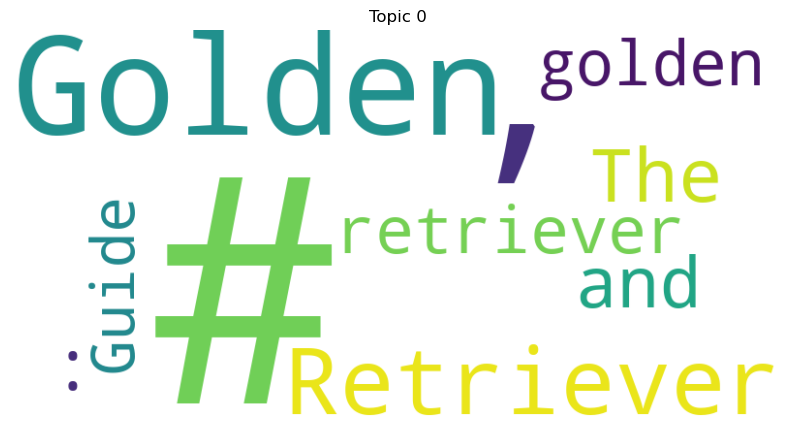

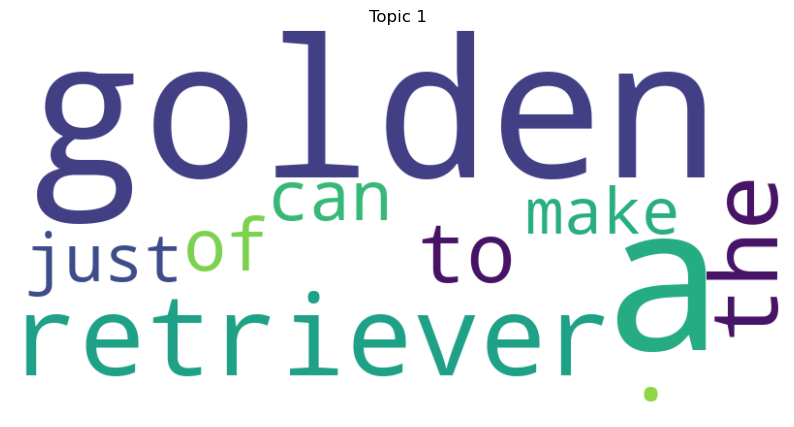

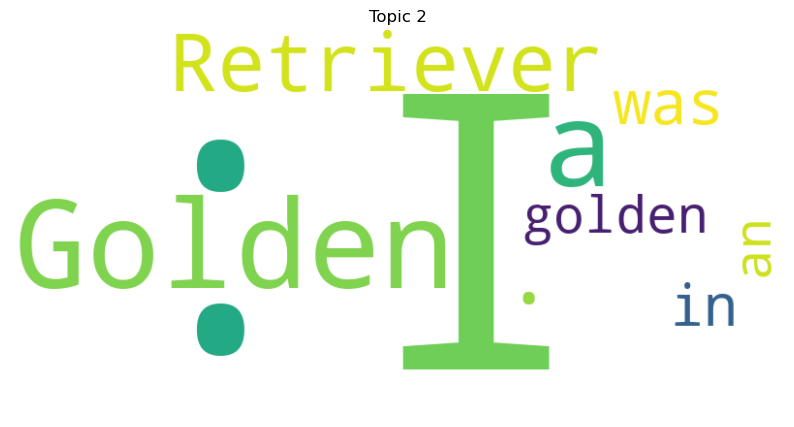

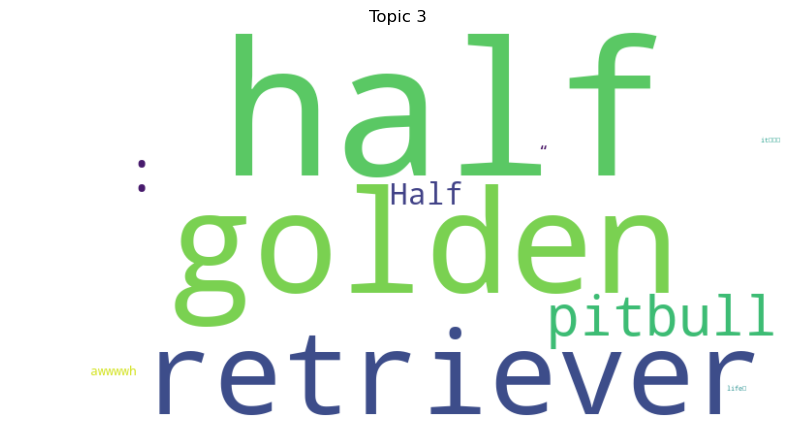

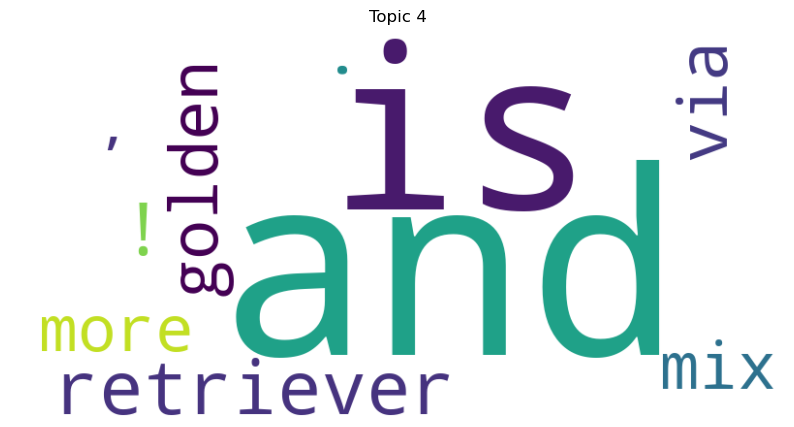

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling/lib/python3.11/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [4]:
import re
import torch
from transformers import BertTokenizer, BertModel
from gensim.corpora import Dictionary
import gensim
import langid
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel

def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    return re.sub(r'http\S+|@\w+|\bRT\b', '', text)

def tokenize_and_embed_tweets(tokenizer, bert_model, tweets):
    """Tokenize and embed tweets using BERT."""
    embeddings = []
    for tweet in tweets:
        encoded_tweet = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**encoded_tweet)
        embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

def train_lda_model(corpus, dictionary):
    """Train an LDA model."""
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,
                                           random_state=42,
                                           passes=10,
                                           per_word_topics=True)

def visualize_wordclouds(lda_model):
    """Visualize Word Clouds for each topic."""
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for topic_id, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis('off')
        plt.show()

def visualize_pyldavis(lda_model, corpus, dictionary):
    """Visualize pyLDAvis."""
    lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

def compute_coherence(lda_model, corpus, dictionary, texts):
    """Compute Topic Coherence."""
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')


# Sample list of 5000 tweet texts
tweet_texts = tweet_text  

# Keep only tweets classified as English
english_tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

# Preprocess and tokenize texts
preprocessed_texts = [preprocess_text(text) for text in english_tweet_texts]

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).eval()

# Tokenize and embed tweets using BERT
bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)

# Convert BERT embeddings to a format suitable for LDA
flattened_bert_embeddings = [emb.flatten() for emb in bert_embeddings]

# Train LDA model on bag-of-words representations
lda_dictionary = Dictionary([word_tokenize(text) for text in preprocessed_texts])
bow_corpus = [lda_dictionary.doc2bow(word_tokenize(text)) for text in preprocessed_texts]
lda_model = train_lda_model(bow_corpus, lda_dictionary)

# Visualizations
visualize_wordclouds(lda_model)
#visualize_pyldavis(lda_model, bow_corpus, lda_dictionary)
compute_coherence(lda_model, bow_corpus, lda_dictionary, preprocessed_texts)


In [5]:
visualize_pyldavis(lda_model, bow_corpus, lda_dictionary)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:
lda_display = gensimvis.prepare(lda_model, bow_corpus, lda_dictionary)
pyLDAvis.display(lda_display)

### Optimized code 2.1

In [ ]:
import re
import os
import concurrent.futures
from transformers import BertTokenizer, BertModel
import torch
import time
from gensim.corpora import Dictionary
import langid
from sklearn.model_selection import train_test_split
import gensim

def preprocess_text(text):
    """Preprocess text by removing URLs, user mentions, and 'RT'."""
    text = re.sub(r'http\S+|@\w+|\bRT\b', '', text)
    return text

def load_or_create_tokenizer(model_name, bert_tokenizer_file):
    """Load or create BERT tokenizer."""
    if not os.path.exists(bert_tokenizer_file):
        tokenizer = BertTokenizer.from_pretrained(model_name)
        tokenizer.save_pretrained(bert_tokenizer_file)
    else:
        tokenizer = BertTokenizer.from_pretrained(bert_tokenizer_file)
    return tokenizer

def tokenize_and_embed_tweets(tokenizer, bert_model, tweets):
    """Tokenize and embed tweets using BERT."""
    def process_tweet(tweet):
        encoded_tweet = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**encoded_tweet)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
        return embeddings

    with concurrent.futures.ThreadPoolExecutor() as executor:
        embeddings = list(executor.map(process_tweet, tweets))
    
    return embeddings

def create_lda_dictionary(texts):
    """Create an LDA dictionary."""
    dictionary = Dictionary(texts)
    dictionary.compactify()
    return dictionary

def train_lda_model(corpus, dictionary):
    """Train an LDA model."""
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                 id2word=dictionary,
                                                 num_topics=5,
                                                 random_state=42,
                                                 passes=10,
                                                 per_word_topics=True)
    return lda_model

# Sample list of 5000 tweet texts
tweet_texts = tweet_text  

# Keep only tweets classified as English
english_tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

start = time.time()

# Preprocess and tokenize texts
preprocessed_texts = [preprocess_text(text) for text in english_tweet_texts]

end = time.time()
print("Time taken for text preprocessing:", end - start, "seconds")

start = time.time()

# Load or create BERT tokenizer
model_name = 'bert-tiny-uncased'
bert_tokenizer_file = 'bert_tokenizer.pth'
tokenizer = load_or_create_tokenizer(model_name, bert_tokenizer_file)

# Load BERT model
bert_model = BertModel.from_pretrained(model_name)
bert_model.eval()

# Tokenize and embed tweets
bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)

end = time.time()
print("Time taken to tokenize and embed tweets:", end - start, "seconds")

start = time.time()

# Convert BERT embeddings to a format suitable for LDA
lda_inputs = [emb.flatten() for emb in bert_embeddings]

end = time.time()
print("Time taken for data conversion for LDA:", end - start, "seconds")

start = time.time()

# Split data into train and test sets
train_inputs, test_inputs = train_test_split(lda_inputs, test_size=0.2, random_state=42)

end = time.time()
print("Time taken for data splitting:", end - start, "seconds")

start = time.time()

# Create LDA dictionary
lda_dictionary = create_lda_dictionary(preprocessed_texts)

# Train LDA model
lda_model = train_lda_model(train_inputs, lda_dictionary)

end = time.time()
print("Time taken for LDA model training:", end - start, "seconds")

### Visualize results

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel

# Visualization 1: Word Clouds for each topic
def visualize_wordclouds(lda_model):
    topics = lda_model.show_topics(num_topics=-1, formatted=False)
    for topic_id, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis('off')
        plt.show()

# Visualization 2: pyLDAvis
def visualize_pyldavis(lda_model, corpus, dictionary):
    lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

# Visualization 3: Topic Coherence
def compute_coherence(lda_model, corpus, dictionary):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=train_tokens, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Topic Coherence Score: {coherence_lda}')



In [ ]:
# Visualize word clouds for each topic
visualize_wordclouds(lda_model)

end = time.time()
print("Time taken for word cloud visualization:", end - start, "seconds")



In [ ]:
start = time.time()

# Visualize topics using pyLDAvis
visualize_pyldavis(lda_model, train_corpus, dictionary)

end = time.time()
print("Time taken for pyLDAvis visualization:", end - start, "seconds")



In [ ]:
start = time.time()

# Compute and print topic coherence score
compute_coherence(lda_model, train_corpus, dictionary)

end = time.time()
print("Time taken for coherence score computation:", end - start, "seconds")

In [8]:
lda_model.num_topics

5